In [1]:
%matplotlib inline
!pip install -q swig
!pip install -q gymnasium
# !pip install -q cupy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 5.9 MB/s eta 0:00:00


## Imports and Environment Setup




In [92]:

from __future__ import annotations

from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
# import cupy as np
import numpy as np
import seaborn as sns
from matplotlib.patches import Patch
from tqdm import tqdm

import gymnasium as gym

env = gym.make("Blackjack-v1", sab=True)

## Agent

In [3]:
class BlackjackAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return env.action_space.sample()

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## Executing an action

In [4]:
# reset the environment to get the first observation
done = False
observation, info = env.reset()

# sample a random action from all valid actions
action = env.action_space.sample()
# action=1

# execute the action in our environment and receive infos from the environment
observation, reward, terminated, truncated, info = env.step(action)

# Training




In [5]:
# hyperparameters
learning_rate = 0.001
n_episodes = 1_000_000
start_epsilon, final_epsilon = 1.0, 0.1

# reduce the exploration over time
epsilon_decay = start_epsilon / (n_episodes / 2)

agent = BlackjackAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

env = gym.wrappers.RecordEpisodeStatistics(env, deque_size=n_episodes)
for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    # single episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 1000000/1000000 [05:38<00:00, 2950.87it/s]


## Visualizing the training




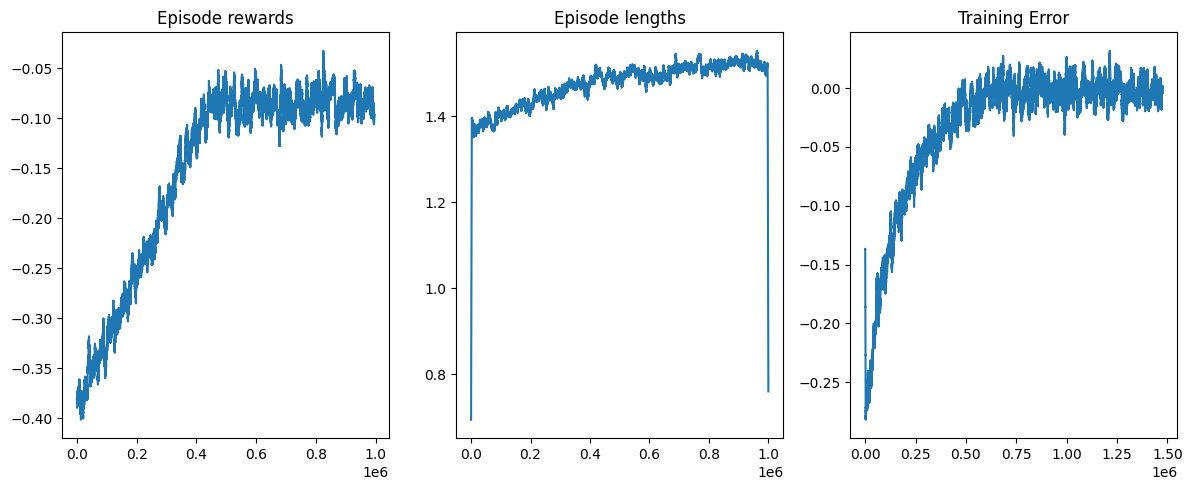

In [6]:
rolling_length = 500 * 10
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

<img src="file://_static/img/tutorials/blackjack_training_plots.png">




## Visualising the policy



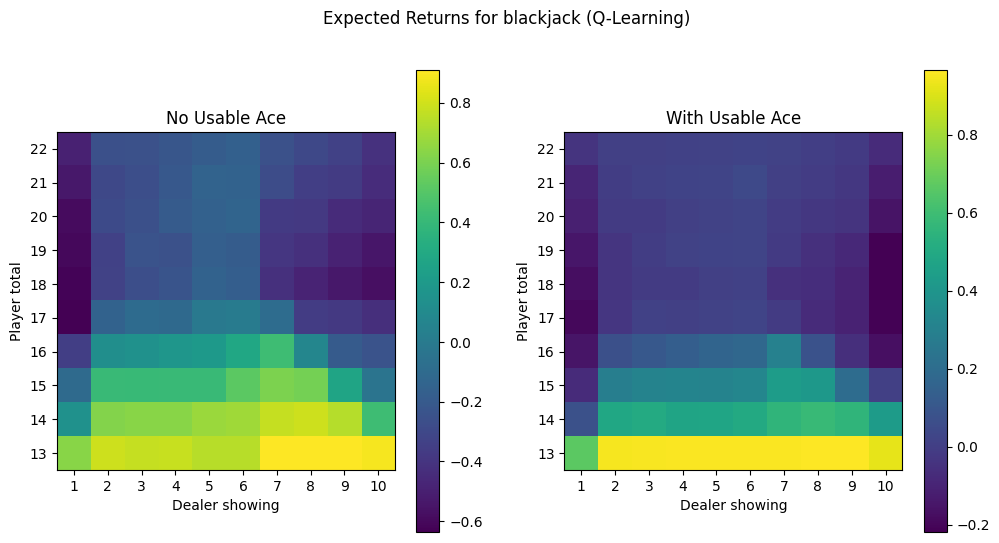

In [67]:
def create_grids(agent, usable_ace=False):
    """Create value and policy grid given an agent."""
    # convert our state-action values to state values
    # and build a policy dictionary that maps observations to actions
    state_value = defaultdict(float)
    policy = defaultdict(int)
    for obs, action_values in agent.q_values.items():
        state_value[obs] = float(np.max(action_values))
        policy[obs] = int(np.argmax(action_values))

    player_count, dealer_count = np.meshgrid(
        # players count, dealers face-up card
        np.arange(12, 22),
        np.arange(1, 11),
    )

    # create the value grid for plotting
    value = np.apply_along_axis(
        lambda obs: state_value[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    value_grid = player_count, dealer_count, value

    # create the policy grid for plotting
    policy_grid = np.apply_along_axis(
        lambda obs: policy[(obs[0], obs[1], usable_ace)],
        axis=2,
        arr=np.dstack([player_count, dealer_count]),
    )
    return value_grid, policy_grid

value_grid, policy_grid = create_grids(agent, usable_ace=False)
player_count, dealer_count, value = value_grid
data1 = value.T

value_grid, policy_grid = create_grids(agent, usable_ace=True)
player_count, dealer_count, value = value_grid
data2 = value.T

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
im1 = axs[0].imshow(data1, cmap='viridis')
axs[0].set_title('No Usable Ace')
axs[0].set_xlabel('Dealer showing')
axs[0].set_ylabel('Player total')
axs[0].set_xticks(np.arange(0, 10, 1))
axs[0].set_yticks(np.arange(0, 10, 1))
axs[0].set_xticklabels(np.arange(1, 11, 1))
axs[0].set_yticklabels(np.arange(22, 12, -1))
plt.colorbar(im1, ax=axs[0])

# Plot the second subplot
im2 = axs[1].imshow(data2, cmap='viridis')
axs[1].set_title('With Usable Ace')
axs[1].set_xlabel('Dealer showing')
axs[1].set_ylabel('Player total')
axs[1].set_xticks(np.arange(0, 10, 1))
axs[1].set_yticks(np.arange(0, 10, 1))
axs[1].set_xticklabels(np.arange(1, 11, 1))
axs[1].set_yticklabels(np.arange(22, 12, -1))
plt.colorbar(im2, ax=axs[1])

# Add a main title to the entire figure
fig.suptitle('Expected Returns for blackjack (Q-Learning)')

plt.show()


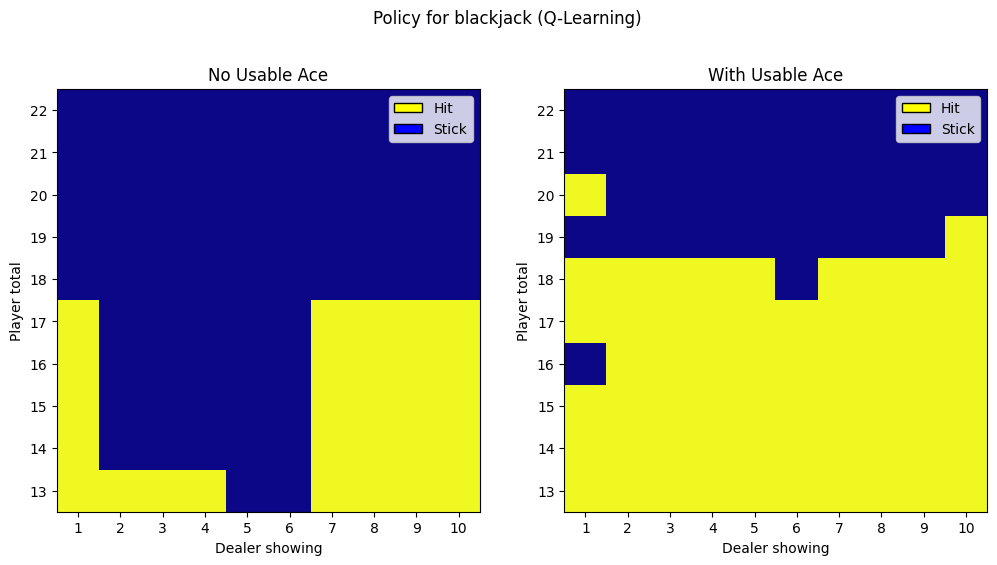

In [78]:
value_grid, policy_grid = create_grids(agent, usable_ace=False)
player_count, dealer_count, value = value_grid
data1 = np.flipud(policy_grid.T)

value_grid, policy_grid = create_grids(agent, usable_ace=True)
player_count, dealer_count, value = value_grid
data2 = np.flipud(policy_grid.T)

# Create the figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
im1 = axs[0].imshow(data1, cmap='plasma')
axs[0].set_title('No Usable Ace')
axs[0].set_xlabel('Dealer showing')
axs[0].set_ylabel('Player total')
axs[0].set_xticks(np.arange(0, 10, 1))
axs[0].set_yticks(np.arange(0, 10, 1))
axs[0].set_xticklabels(np.arange(1, 11, 1))
axs[0].set_yticklabels(np.arange(22, 12, -1))

# Plot the second subplot
im2 = axs[1].imshow(data2, cmap='plasma')
axs[1].set_title('With Usable Ace')
axs[1].set_xlabel('Dealer showing')
axs[1].set_ylabel('Player total')
axs[1].set_xticks(np.arange(0, 10, 1))
axs[1].set_yticks(np.arange(0, 10, 1))
axs[1].set_xticklabels(np.arange(1, 11, 1))
axs[1].set_yticklabels(np.arange(22, 12, -1))

# Add a main title to the entire figure
fig.suptitle('Policy for blackjack (Q-Learning)')

legend_elements = [
    Patch(facecolor="yellow", edgecolor="black", label="Hit"),
    Patch(facecolor="blue", edgecolor="black", label="Stick"),
]
axs[0].legend(handles=legend_elements, bbox_to_anchor=(1, 1))
axs[1].legend(handles=legend_elements, bbox_to_anchor=(1, 1))
plt.show()


In [81]:
env2 = gym.make("Blackjack-v1", sab=True)

n_episodes = 100_000

done = False
observation, info = env2.reset()

env2 = gym.wrappers.RecordEpisodeStatistics(env2, deque_size=n_episodes)
win, lose, tie = 0, 0, 0

for episode in tqdm(range(n_episodes)):
    obs, info = env2.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env2.step(action)

        # update if the environment is done and the current obs
        done = terminated or truncated
        if done:
          if reward > 0:
              win += 1
          elif reward < 0:
              lose += 1
          else:
              tie += 1
        obs = next_obs

100%|██████████| 100000/100000 [00:29<00:00, 3368.51it/s]


Win: 41555	(41.555%)
Lose: 49937	(49.937%)
Tie: 8508	(8.508000000000001%)



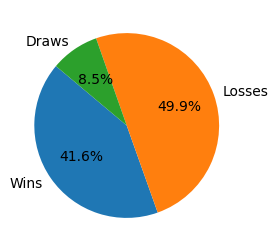

,Wins,Losses,Draws
0,41.555,49.937,8.508


In [96]:
total_game = win + lose + tie

print("Win: {}\t({}%)\nLose: {}\t({}%)\nTie: {}\t({}%)\n".format(win, win/total_game*100, lose, lose/total_game*100, tie, tie/total_game*100))

# Data for the pie chart
data = [win, lose, tie]
labels = ['Wins', 'Losses', 'Draws']

# Create a pie plot
plt.figure(figsize=(3, 3))
plt.pie(data, labels=labels, autopct='%1.1f%%', startangle=140)

# Display the plot
plt.show()

dict = {'Wins' : [win/total_game*100],
        'Losses' : [lose/total_game*100],
        'Draws' : [tie/total_game*100]
        }
df = pd.DataFrame(dict)

display(df)